**Acknowledgement:** This notebook is inspired from https://github.com/glouppe/info8010-deep-learning/tree/master/tutorials/lecture_01/notebook

# Polynomial Regression with PyTorch


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
my_seed = 1
import numpy as np
np.random.seed(my_seed)
import torch
torch.manual_seed(my_seed)
import torch.nn as nn
dtype = torch.FloatTensor

## Data generation

We have access to a dataset $\mathcal{D} = \{(x_i, y_i)\}_{i=1}^N$ where the pairs $(x_i, y_i)$ are assumed to be independent and identically distributed (i.i.d) according to an unknown distribution $p^\star(x, y)$:

$$ (x_i, y_i) \overset{i.i.d}{\sim} p^\star(x, y).$$

Actually, in this example, we are going to generate a synthetic dataset from a known distribution $p^\star(x, y)$. But in general, when you collect data in the wild, keep in mind that **you do not know the true underlying data distribution**. 

The data are generated according to $ p^\star(x, y) = p^\star(y|x)p^\star(x)$, where

$$ p^\star(x) = \mathcal{U}([-20,20]); $$
$$ p^\star(y|x) = \mathcal{N}(g(x), \sigma^2),$$ 

with $g(x) = 0.1 (x-2)^3 + x^2 - 8x - 1$.

In practice, we first sample $x$ from the uniform distribution $\mathcal{U}([-20,20])$ and $\epsilon$ from the Gaussian distribution $\mathcal{N}(0, \sigma^2)$, then we compute $y = g(x) + \epsilon$. We repeat this process independently $N$ times to build $\mathcal{D} = \{(x_i, y_i)\}_{i=1}^N$.

Let's generate and visualize our synthetic dataset.

In [ ]:
def g(x):
    # the true polynomial g(x)
    return 0.1 * (x-2) ** 3 + x ** 2 - 8.0 * x - 1.0

def generate(N):
    # dataset generation
    x = np.random.rand(N) * 40.0 - 20.0
    y = g(x) + 50 * np.random.randn(N)
    
    return x.reshape(N, 1), y.reshape(N, 1)

N = 50 # number of samples
x_train, y_train = generate(N) # dataset

print(x_train.shape)
print(y_train.shape)

(50, 1)
(50, 1)


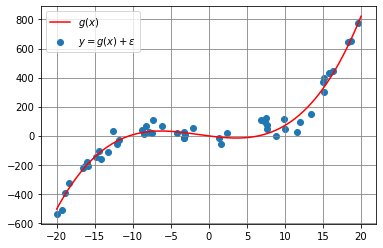

In [ ]:
xs = np.linspace(-20, 20, num=1000)
plt.plot(xs, g(xs), c="r", label="$g(x)$")
plt.scatter(x_train, y_train, label="$y = g(x) + \epsilon$")
plt.legend(loc='upper left')
plt.grid(color="grey")
plt.show()

## Vanilla linear neural network

We want to find a function $f_\theta: \mathbb{R} \mapsto \mathbb{R}$ parameterized by $\theta \in \mathbb{R}^P$ such that on average over $p^\star(x,y)$, $y$ is well approximated by $f_\theta(x)$.

**Model definition:** Assume that we have no idea about the true data $p^\star(x,y)$. A first thing to try is to fit a simple linear model. We thus define $f_\theta(x) = w x + b$, where $\theta = (w,b) \in \mathbb{R}^2$. 

This linear model is defined in the following cell, using the base class for all neural networks in Pytorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), a linear layer [torch.nn.Linear](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear), and an identity activation function, which is useless here but it is introduced for generality purposes (you should follow a similar template when using non-linear activation functions).

In [ ]:
class MyFirstNN(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyFirstNN, self).__init__() # mandatory for all models based on torch.nn.Module
        self.fc = nn.Linear(input_dim, output_dim) # we define a linear layer
        self.act_fn = nn.Identity() # we define an identity activation function
        
    def forward(self, x):
        # This method is mandatory for all models based on torch.nn.Module. 
        # It defines the forward pass in the neural network, i.e. computing the output given the input
        # as parameter. You have to use the layers and activation functions that were defined in the __init__ 
        # method.
    
        return self.act_fn(self.fc(x))

We can instantiate this model:

In [ ]:
my_nn1 = MyFirstNN(1, 1)

print(my_nn1)

MyFirstNN(
  (fc): Linear(in_features=1, out_features=1, bias=True)
  (act_fn): Identity()
)


**Loss definition:** We also have to define a loss, in order to measure the quality of our prediction $\hat{y} := f_\theta(x)$ with respect to the ground truth $y$, for $(x,y) \sim p^\star(x,y)$. For this regression problem, we use the squared error:

$$ \mathcal{l}(y, f_\theta(x)) = (y - f_\theta(x))^2.$$

Following the principle of empirical risk minimization, we want to estimate the model parameters $\theta$ that minimize the average loss over the training dataset $\mathcal{D}$. The empirical risk (i.e. the global loss to minimize) is defined by:

$$ \mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^N \mathcal{l}(y_i, f_\theta(x_i)) = \frac{1}{N} \sum_{i=1}^N (y_i - f_\theta(x_i))^2,$$

which corresponds to the mean squared error. In the following cell, we define this loss with [torch.nn.MSELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.MSELoss).

In [ ]:
loss_fn = nn.MSELoss(reduction='mean')

**Minimization algorithm:** We use standard gradient descent to minimize $\mathcal{L}(\theta)$, which is implemented in [torch.optim.SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD). When instantiating this class, we need to provide the list of model parameters and the learning rate (see the ```train``` function below).

In [ ]:
optimizer = torch.optim.SGD

**Training with PyTorch** We now have to train this model using our dataset. The following function gives you the basic PyTorch cooking recipe that you should follow to train a model.

In [ ]:
def train(x, y, my_nn, loss_fn, optimizer, learning_rate, num_epoch):
    
    # We turn our model in train mode. Some layers that we do not use here 
    # behave differently on train and eval mode. 
    my_nn.train() 
    
    # We define the optimizer
    optimizer = optimizer(my_nn.parameters(), lr=learning_rate)
    
    train_loss = []
    
    for epoch in range(num_epoch):

        my_nn.zero_grad() # reset the stored gradients for the parameters of the neural network

        y_hat = my_nn(x) # do the forward pass

        loss = loss_fn(y_hat, y) # compute the loss
        # this is equivalent to:
        # loss = (y_pred - y_train_tensor).pow(2).mean()    

        loss.backward() # do the backward pass

        optimizer.step() # do a SGD step
        ## this is equivalent to:
        # for p in my_nn1.parameters():
        #    p.data = p.data - learning_rate*p.grad.data

        train_loss.append(loss.item()) # store the loss
    
    return train_loss

Let's train and visualize the results.

In [ ]:
# convert input/output data to tensors
x_train_tensor = torch.from_numpy(x_train).type(dtype)
y_train_tensor = torch.from_numpy(y_train).type(dtype)

# training
train_loss = train(x=x_train_tensor, 
                   y=y_train_tensor, 
                   my_nn=my_nn1, 
                   loss_fn=loss_fn, 
                   optimizer=optimizer, 
                   learning_rate=1e-3, 
                   num_epoch=40)

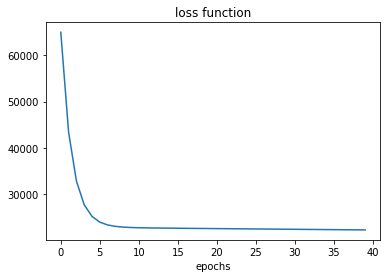

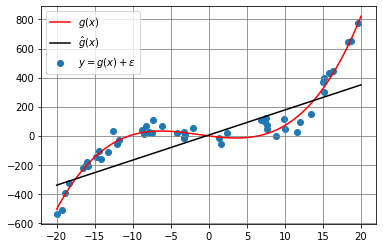

In [ ]:
def plot_results(loss, my_nn):
    
    # plot loss
    plt.figure()
    plt.plot(loss)
    plt.title('loss function')
    plt.xlabel('epochs')
    
    # plot learned function
    xs = np.linspace(-20, 20, num=1000)
    xs_tensor = torch.from_numpy(xs).type(dtype).unsqueeze(1)
    with torch.no_grad():
        y_pred = my_nn(xs_tensor).numpy()

    plt.figure()
    plt.plot(xs, g(xs), c="r", label="$g(x)$")
    plt.scatter(x_train, y_train, label="$y = g(x) + \epsilon$")
    plt.plot(xs, y_pred, c="k", label="$\hat{g}(x)$")
    plt.legend(loc='upper left')
    plt.grid(color="grey")
    plt.show()
    
plot_results(train_loss, my_nn1)

As expected, we obtain a very poor prediction (black curve). Indeed, we cannot fit a polynomial with a linear model. 

## Polynomial regression with PyTorch

To overcome the limitations of the previous linear model, define a polynomial model called ```MySecondNN``` (a class inheritating from [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), similarly as before). Train it and visualize the results, similarly as before. 

You should be able to define the appropriate model by only using the following functions/classes:

- [torch.nn.Linear](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)
- [torch.pow](https://pytorch.org/docs/stable/torch.html#torch.pow)  or `**`
- [torch.cat](https://pytorch.org/docs/stable/torch.html?highlight=torch%20cat#torch.cat) 

Remember that the learning rate and the number of epochs are important parameters of the gradient descent algorithm...

In [ ]:
class MySecondNN(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MySecondNN, self).__init__()
        self.fc = nn.Linear(3*input_dim, output_dim)
        
    def forward(self, x):
        
        x_ext = torch.cat((x.pow(3), x.pow(2), x), 1)
        return self.fc(x_ext)


In [ ]:
my_nn2 = MySecondNN(1, 1)

train_loss = train(x=x_train_tensor, 
                   y=y_train_tensor, 
                   my_nn=my_nn2, 
                   loss_fn=loss_fn, 
                   optimizer=optimizer, 
                   learning_rate=1e-8, 
                   num_epoch=40)

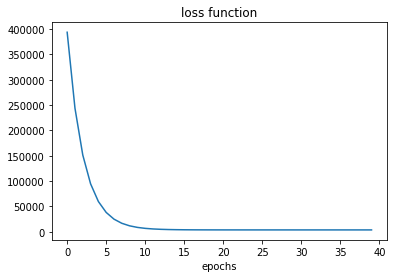

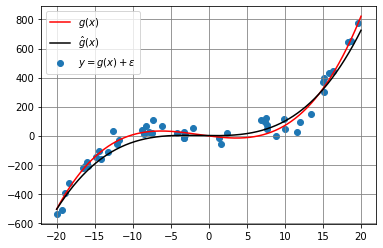

In [ ]:
plot_results(train_loss, my_nn2)

## Polynomial fit with a multi-layer perceptron

The previous model is polynomial with respect to the input, but **linear** with respect to the model parameters. We could actually fit a standard multilayer perceptron on our training samples. The resulting model would be **non-linear** with respect to the model parameters. This is what we do below. 

In [ ]:
class MyThirdNN(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim):
        super(MyThirdNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ReLU() # we use Rectified Linear Units activations
        
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        
        return x


In [ ]:
my_nn3 = MyThirdNN(1, 1, 50)

# standard gradient descent gives poor results here, so we choose another optimization method called Adam
optimizer = torch.optim.Adam 

train_loss = train(x=x_train_tensor, 
                   y=y_train_tensor, 
                   my_nn=my_nn3, 
                   loss_fn=loss_fn, 
                   optimizer=optimizer, 
                   learning_rate=1e-2, 
                   num_epoch=1000)

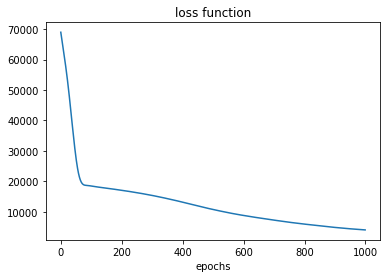

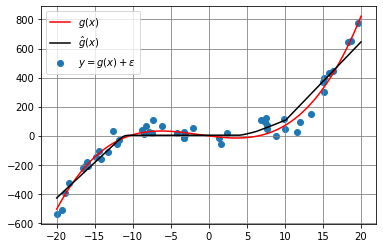

In [ ]:
plot_results(train_loss, my_nn3)

The resulting model is ok, but it is clearly not better, or maybe even worse than the previous one, which moreover has much less parameters. Simple linear models can sometimes do a better job than neural networks....